In [4]:
import sys
sys.path.append('../utils')  

from font import set_korean_font
set_korean_font()

신재생 발전량 대비 소비량 비율(자립도) → 지역 에너지 자급 수준 평가

In [5]:
import pandas as pd

# 지역별 신재생 에너지 발전량 데이터 불러오기
renewable_df = pd.read_excel('../Data/지역별 신재생 에너지 발전량.xlsx')

# 연도별 지역별 전력 사용량 데이터 불러오기
consumption_df = pd.read_csv('../Data/연도별 지역별 전력 사용량.csv')

# 연도별 지역별 전력 사용량 데이터 불러오기
powergen_df = pd.read_csv('../Data/HOME_발전·판매_발전량_지역별.csv',encoding='cp949' )

In [6]:
print("신재생 발전량 데이터의 광역지자체 고유값:")
print(renewable_df['시도코드'].unique())

print("전력 소비량 데이터의 광역지자체 고유값:")
print(consumption_df['시도코드'].unique())

print("신재생 발전량 데이터의 연도 고유값:")
print(renewable_df['연도'].unique())

print("전력 소비량 데이터의 연도 고유값:")
print(consumption_df['연도'].unique())


신재생 발전량 데이터의 광역지자체 고유값:
[11 26 27 28 29 30 31 36 41 51 43 44 52 46 47 48 50]
전력 소비량 데이터의 광역지자체 고유값:
[51 41 48 47 29 27 30 26 11 36 31 28 46 52 50 44 43]
신재생 발전량 데이터의 연도 고유값:
[2023 2022 2021]
전력 소비량 데이터의 연도 고유값:
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [7]:
# 두 데이터 병합 (광역지자체와 연도를 기준으로)
merged_df = pd.merge(renewable_df, consumption_df, on=['시도코드', '연도'])

# 자립도 계산
merged_df['자립도(%)'] = (merged_df['신재생에너지 합계'] / merged_df['총합']) * 100

# 시도코드 → 광역지자체 매핑 (숫자 -> 광역지자체 이름)
code_to_sido = {
    "11": "서울",
    "26": "부산",
    "27": "대구",
    "28": "인천",
    "29": "광주",
    "30": "대전",
    "31": "울산",
    "36": "세종",
    "41": "경기",
    "51": "강원",
    "43": "충북",
    "44": "충남",
    "52": "전북",
    "46": "전남",
    "47": "경북",
    "48": "경남",
    "50": "제주"
}

# '시도코드'를 기준으로 '광역지자체' 이름 추가 (매핑되지 않으면 'Unknown' 처리)
merged_df['광역지자체'] = merged_df['시도코드'].astype(str).map(code_to_sido).fillna('Unknown')

# 결과 출력
print(merged_df.head())


     연도 광역지자체_x  신재생에너지 합계  재생에너지 합계  신에너지 합계  신재생에너지공급비중     태양광     풍력  \
0  2023      서울     755498    361266   394232        1.25  272765    184   
1  2023      부산     738393    421541   316852        1.22  366024     63   
2  2023      대구     560890    544440    16450        0.93  497336  16525   
3  2023      인천    1966319    574288  1392031        3.26  267782  24693   
4  2023      광주     598721    418128   180593        0.99  404724      7   

      수력  해양  ...         교육용        농사용          산업용          일반용  \
0    334   0  ...  1885995252   22301529   4864337700  26697377957   
1    127   0  ...   494325327  117551852   8066176822   7250861600   
2  14033   0  ...   382717124  128901809   6680984976   5012744050   
3  13477   0  ...   394573429  164846184  12954064245   7015460966   
4   5028   0  ...   311703341   91873294   3084244048   3133763207   

           주택용 심야         기타           총합    자립도(%)  광역지자체  
0  15058819147  0  429133956  49218955893  0.001535     서울  


In [8]:
# 석탄 발전 기준 평균 탄소 배출 계수 
carbon_emission_factor = 0.424  # kgCO2/kWh

# 탄소 회피량(톤) 계산
merged_df['탄소회피량'] = merged_df['자립도(%)'] * merged_df['총합'] * 1000 * carbon_emission_factor / 1000


상관계수:           자립도(%)     탄소회피량
자립도(%)  1.000000  0.648712
탄소회피량   0.648712  1.000000


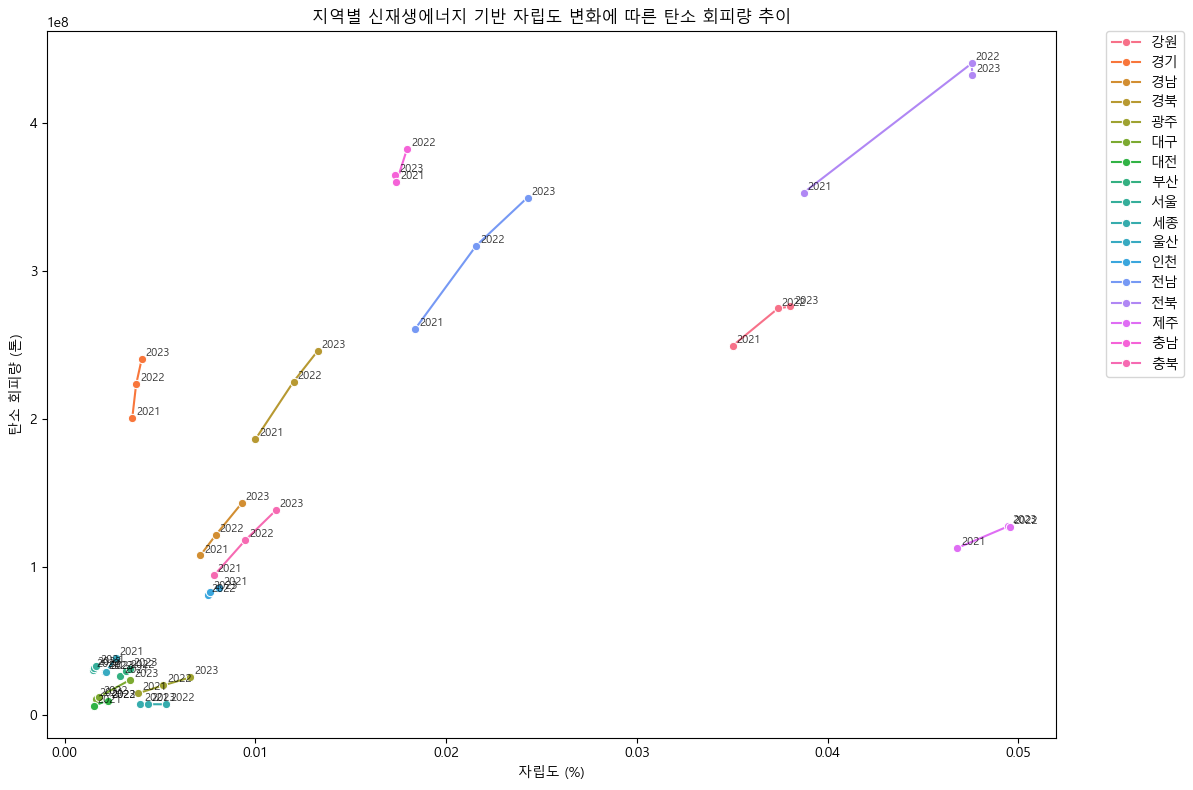

상관계수: 0.6487
p-value: 2.6323e-07


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_df['연도'] = merged_df['연도'].astype(str)

# 상관계수 확인
print("상관계수:", merged_df[['자립도(%)', '탄소회피량']].corr())

# 연도 오름차순 정렬
merged_df = merged_df.sort_values(by=['광역지자체', '연도'])

plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='자립도(%)', y='탄소회피량', hue='광역지자체', marker='o')

# 각 점에 연도 라벨 표시
for i, row in merged_df.iterrows():
    plt.text(row['자립도(%)'] + 0.0002, row['탄소회피량'] + 2e6,   
             str(row['연도']),
             fontsize=8,
             alpha=0.8)

plt.title('지역별 신재생에너지 기반 자립도 변화에 따른 탄소 회피량 추이')
plt.xlabel('자립도 (%)')
plt.ylabel('탄소 회피량 (톤)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

from scipy.stats import pearsonr

# 상관계수와 p-value 계산
corr, p_value = pearsonr(merged_df['자립도(%)'], merged_df['탄소회피량'])

print(f"상관계수: {corr:.4f}")
print(f"p-value: {p_value:.4e}")


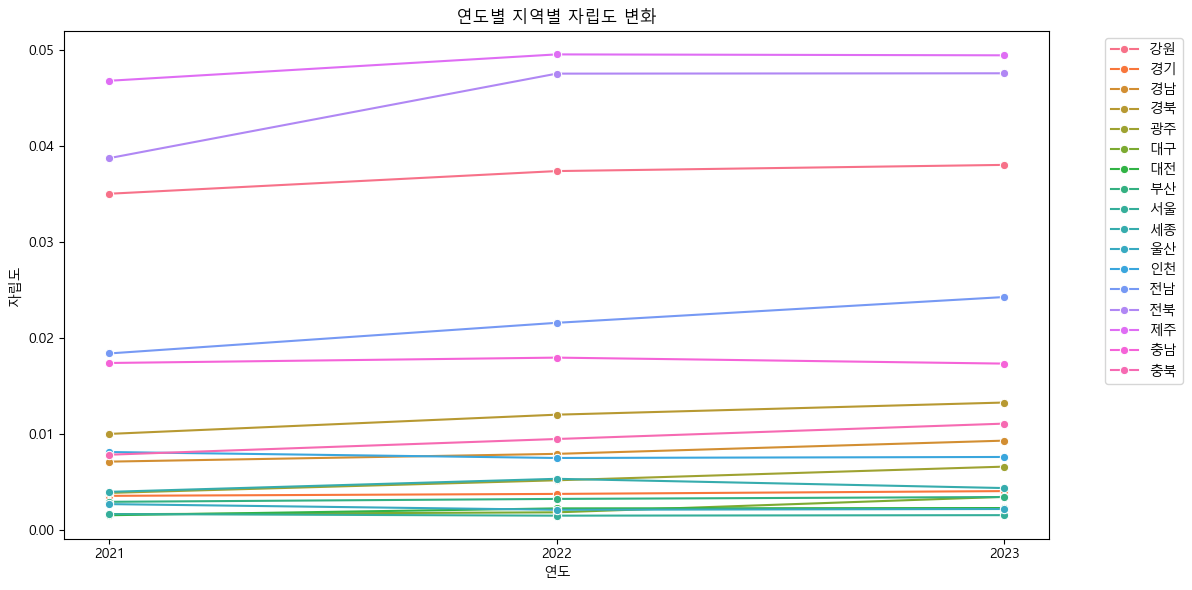

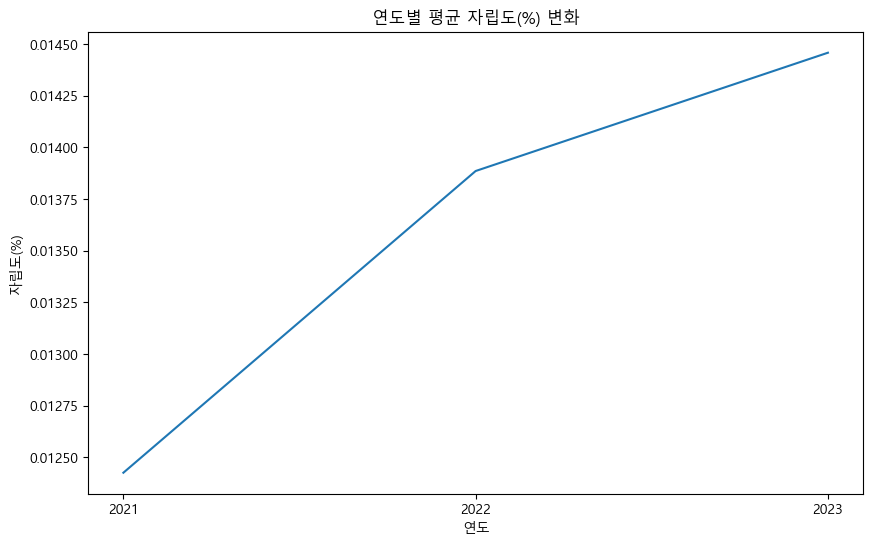

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# 연도별 자립도 평균 계산
yearly_self_suff = merged_df.groupby('연도')['자립도(%)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='연도', y='자립도(%)', hue='광역지자체', marker='o')

plt.title('연도별 지역별 자립도 변화')
plt.xlabel('연도')
plt.ylabel('자립도')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_self_suff , x='연도', y='자립도(%)')
plt.title('연도별 평균 자립도(%) 변화')
plt.show()



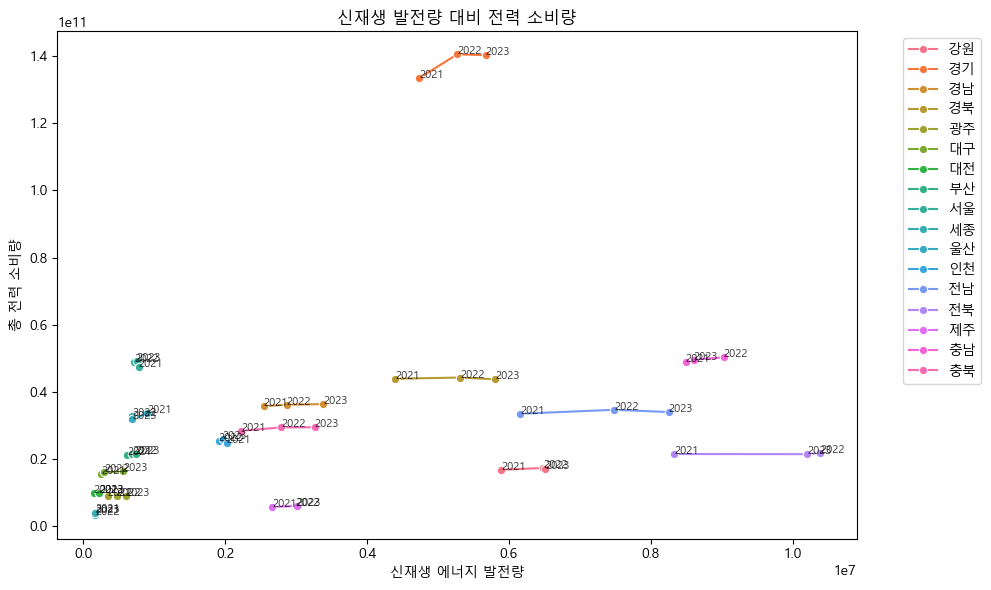

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 연도와 광역지자체별로 신재생 발전량과 전력 소비량 합산
yearly_data = merged_df.groupby(['연도', '광역지자체'])[['신재생에너지 합계', '총합']].sum().reset_index()

# 시각화: 신재생 발전량 vs 전력 소비량
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='신재생에너지 합계', y='총합', hue='광역지자체', marker='o')
# 각 점에 연도 라벨 표시
for i, row in merged_df.iterrows():
    plt.text(row['신재생에너지 합계'] + 0.0002, row['총합'] + 2e6,   
             str(row['연도']),
             fontsize=8,
             alpha=0.8)


plt.title('신재생 발전량 대비 전력 소비량')
plt.xlabel('신재생 에너지 발전량')
plt.ylabel('총 전력 소비량')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

신재생 발전량과 전력 소비량 간 상관계수: 0.314
     연도 광역지자체       자립도 자립도 평가
0  2021    강원  0.000350     낮음
1  2021    경기  0.000035     낮음
2  2021    경남  0.000071     낮음
3  2021    경북  0.000100     낮음
4  2021    광주  0.000039     낮음
5  2021    대구  0.000016     낮음
6  2021    대전  0.000015     낮음
7  2021    부산  0.000029     낮음
8  2021    서울  0.000017     낮음
9  2021    세종  0.000040     낮음


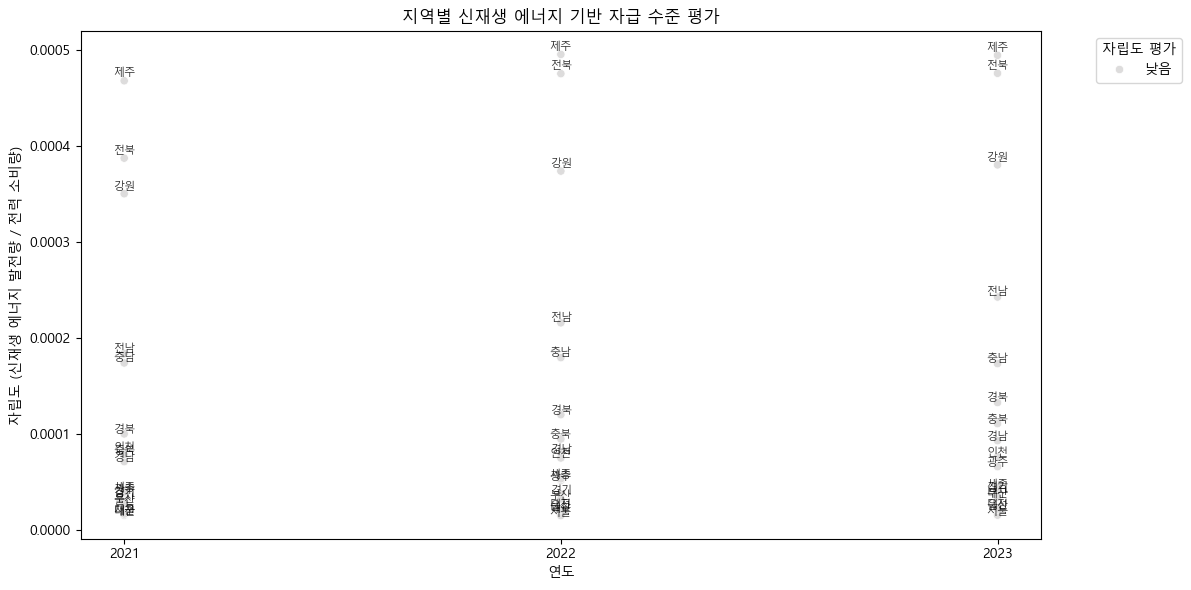

In [12]:
# 상관계수 계산
correlation = yearly_data[['신재생에너지 합계', '총합']].corr().iloc[0, 1]
print(f"신재생 발전량과 전력 소비량 간 상관계수: {correlation:.3f}")

import pandas as pd

# 연도별, 광역지자체별로 신재생 발전량과 전력 소비량 합산
yearly_data = merged_df.groupby(['연도', '광역지자체'])[['신재생에너지 합계', '총합']].sum().reset_index()

# 자립도 계산: 신재생 에너지 발전량 / 총 전력 소비량
yearly_data['자립도'] = yearly_data['신재생에너지 합계'] / yearly_data['총합']

# 자립도 평가 기준에 따른 분류
def classify_energy_self_sufficiency(ratio):
    if ratio >= 1:
        return '높음'
    elif ratio >= 0.5:
        return '중간'
    else:
        return '낮음'

# 자립도 평가 추가
yearly_data['자립도 평가'] = yearly_data['자립도'].apply(classify_energy_self_sufficiency)

# 자립도 평가 결과 출력
evaluation_result = yearly_data[['연도', '광역지자체', '자립도', '자립도 평가']]
print(evaluation_result.head(10))

# 자립도 평가 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 자립도 평가 분포 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=yearly_data, x='연도', y='자립도', hue='자립도 평가', palette='coolwarm', marker='o')

for i, row in yearly_data.iterrows():
    # y 값에 오프셋을 자립도 값의 5%로 조정하여 라벨이 겹치지 않도록 함
    offset = row['자립도'] * 0.01
    plt.text(row['연도'], row['자립도'] + offset, f"{row['광역지자체']}", fontsize=8, alpha=0.8, ha='center')

plt.title('지역별 신재생 에너지 기반 자급 수준 평가')
plt.xlabel('연도')
plt.ylabel('자립도 (신재생 에너지 발전량 / 전력 소비량)')
plt.legend(title='자립도 평가', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

      연도 광역지자체  신재생에너지 합계            총합  신재생 발전량 증가율 (%)    자립도(%)
17  2022    강원    6479493   17325520416        10.028228  0.037399
18  2022    경기    5269025  140531011870        11.305821  0.003749
19  2022    경남    2867620   36190919775        12.803120  0.007924
20  2022    경북    5315057   44263948626        20.974941  0.012008
21  2022    광주     471271    9116870722        36.307525  0.005169
22  2022    대구     293356   16039260228        16.498022  0.001829
23  2022    대전     224281   10016877129        50.654594  0.002239
24  2022    부산     693590   21493647968        12.552658  0.003227
25  2022    서울     723176   48788677386        -7.554997  0.001482
26  2022    세종     169375    3182079288        -0.498755  0.005323
27  2022    울산     689744   32919180716       -23.559419  0.002095
28  2022    인천    1911643   25506863978        -5.378073  0.007495
29  2022    전남    7481402   34665104612        21.485430  0.021582
30  2022    전북   10385213   21838473954        24.740276  0.04

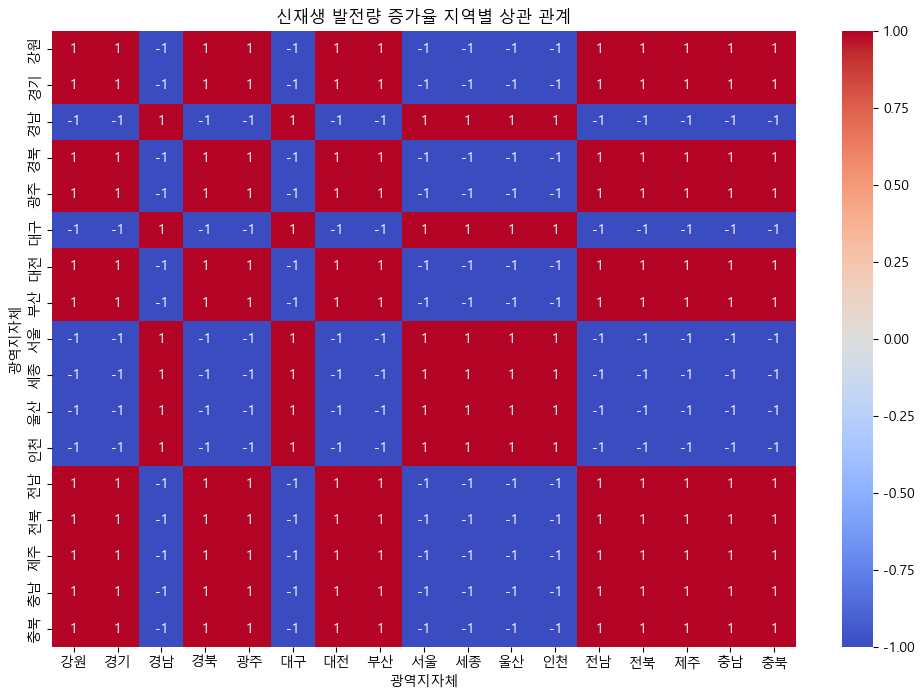

강원의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
경기의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
경남의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
경북의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
광주의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
대구의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
대전의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
부산의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
서울의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
세종의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
울산의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
인천의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
전남의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
전북의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000
제주의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
충남의 신재생 발전량 증가율과 자립도 간 상관계수: 1.000
충북의 신재생 발전량 증가율과 자립도 간 상관계수: -1.000


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 연도별 신재생에너지 발전량과 전력 소비량 데이터
yearly_data = merged_df.groupby(['연도', '광역지자체'])[['신재생에너지 합계', '총합']].sum().reset_index()

# 발전량 증가율 계산 (현재 연도 대비 이전 연도 증가율)
yearly_data['신재생 발전량 증가율 (%)'] = yearly_data.groupby('광역지자체')['신재생에너지 합계'].pct_change() * 100

# 자립도 계산
yearly_data['자립도(%)'] = yearly_data['신재생에너지 합계'] / yearly_data['총합'] * 100
# print(yearly_data)

# 1. 데이터 필터링 및 NaN 처리
yearly_data_filtered = yearly_data.dropna(subset=['신재생 발전량 증가율 (%)', '자립도(%)'])
print(yearly_data_filtered)

# 2. 피벗 테이블 생성 (단일 지표 사용)
pivot_df = yearly_data_filtered.pivot_table(
    index='연도', 
    columns='광역지자체', 
    values='신재생 발전량 증가율 (%)'  # 자립도(%) 대신 하나 선택
)

# 3. 상관계수 계산 전 데이터 확인
print("최종 데이터 구조:", pivot_df.shape)
print(pivot_df)

# 4. 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('신재생 발전량 증가율 지역별 상관 관계')
plt.show()

# 각 지역별로 상관계수 출력
for region in yearly_data_filtered['광역지자체'].unique():
    region_data = yearly_data_filtered[yearly_data_filtered['광역지자체'] == region]
    correlation = region_data[['신재생 발전량 증가율 (%)', '자립도(%)']].corr().iloc[0, 1]
    print(f"{region}의 신재생 발전량 증가율과 자립도 간 상관계수: {correlation:.3f}")



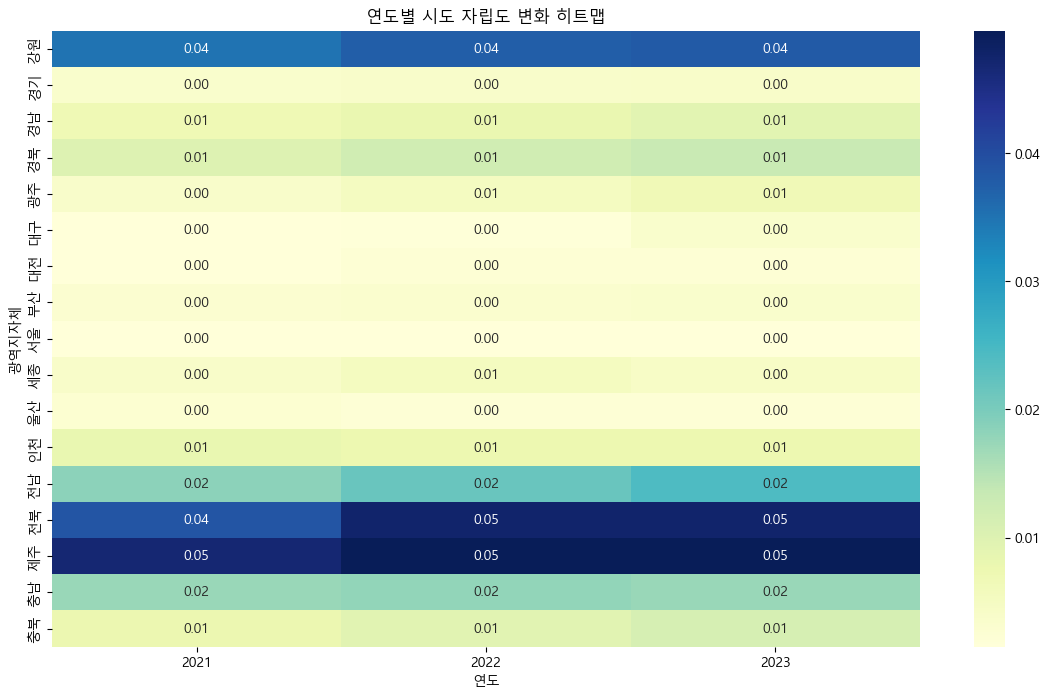

In [14]:
pivot_df = merged_df.pivot_table(index='광역지자체', columns='연도', values='자립도(%)')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("연도별 시도 자립도 변화 히트맵")
plt.show()

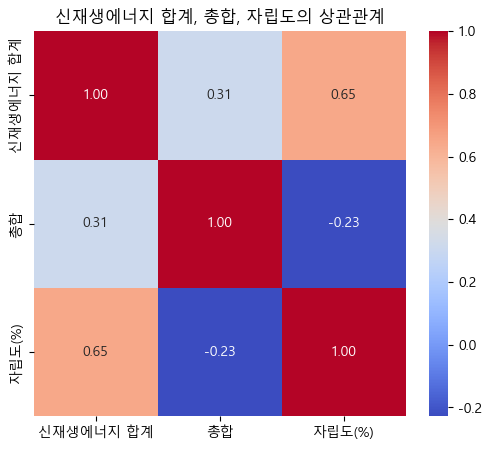

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 분석
corr_matrix = merged_df[['신재생에너지 합계', '총합', '자립도(%)']].corr()

# heatmap 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("신재생에너지 합계, 총합, 자립도의 상관관계")
plt.show()


발전량 대비 자립도

In [16]:
print(powergen_df.columns)
print(consumption_df.columns)

Index(['연도', '서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북',
       '충남', '전북', '전남', '경북', '경남', '제주'],
      dtype='object')
Index(['연도', '광역지자체', '시도코드', '가로등', '교육용', '농사용', '산업용', '일반용', '주택용', '심야',
       '기타', '총합'],
      dtype='object')


In [17]:
import pandas as pd

# 시도명 → 시도코드 매핑
sido_to_code = {
    "서울": "11", "부산": "26", "대구": "27", "인천": "28", "광주": "29",
    "대전": "30", "울산": "31", "세종": "36", "경기": "41", "강원": "51",
    "충북": "43", "충남": "44", "전북": "52", "전남": "46", "경북": "47",
    "경남": "48", "제주": "50"
}

# 1. powergen_df melt (wide → long)
powergen_long = powergen_df.melt(id_vars='연도', var_name='시도명', value_name='발전량')

# 2. 시도명 → 시도코드 매핑
powergen_long['시도코드'] = powergen_long['시도명'].map(sido_to_code)

# 시도코드를 모두 문자열(str)로 변환
powergen_long['시도코드'] = powergen_long['시도코드'].astype(str)
consumption_df['시도코드'] = consumption_df['시도코드'].astype(str)


# 3. 병합
merged_df2 = pd.merge(powergen_long, consumption_df, on=['시도코드', '연도'])
# 자립도 계산
merged_df2['자립도(%)'] = (merged_df2['발전량'] / merged_df2['총합']) * 100

print(merged_df2.columns)

Index(['연도', '시도명', '발전량', '시도코드', '광역지자체', '가로등', '교육용', '농사용', '산업용', '일반용',
       '주택용', '심야', '기타', '총합', '자립도(%)'],
      dtype='object')


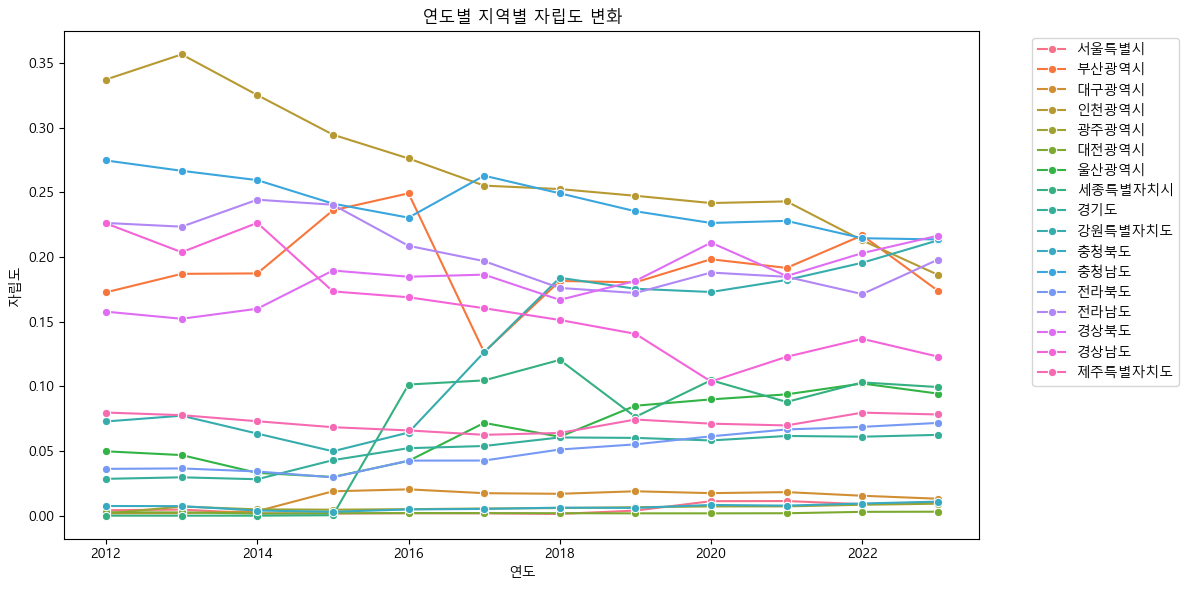

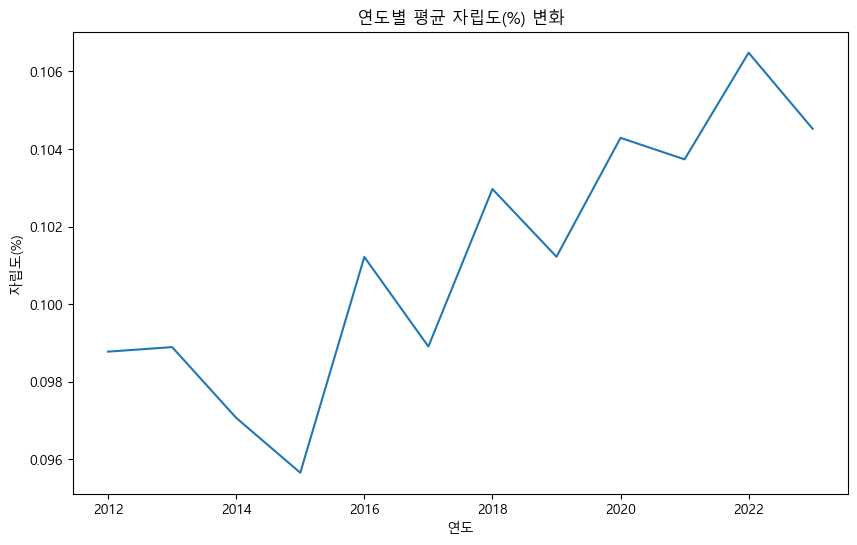

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# 연도별 자립도 평균 계산
yearly_self_suff = merged_df2.groupby('연도')['자립도(%)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df2, x='연도', y='자립도(%)', hue='광역지자체', marker='o')

plt.title('연도별 지역별 자립도 변화')
plt.xlabel('연도')
plt.ylabel('자립도')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_self_suff , x='연도', y='자립도(%)')
plt.title('연도별 평균 자립도(%) 변화')
plt.show()



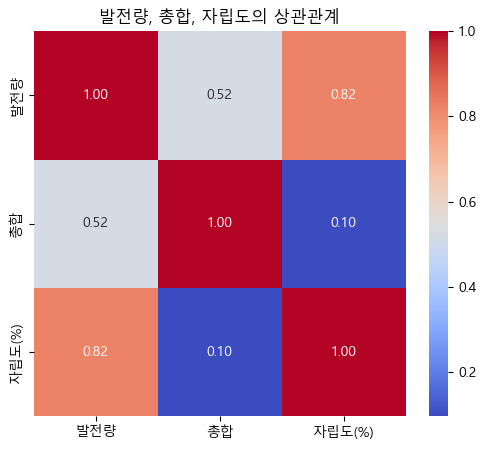

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 분석
corr_matrix = merged_df2[['발전량', '총합', '자립도(%)']].corr()

# heatmap 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("발전량, 총합, 자립도의 상관관계")
plt.show()


In [20]:
# 자립도 낮지만 발전량 많은 지역 (상대적으로 수요가 많은 지역)
high_gen_low_self = merged_df2[(merged_df2['발전량'] > merged_df2['발전량'].quantile(0.75)) &
                               (merged_df2['자립도(%)'] < merged_df2['자립도(%)'].quantile(0.25))]

# 자립도 높은데 총합 적은 지역 (발전 집중된 지역)
low_total_high_self = merged_df2[(merged_df2['총합'] < merged_df2['총합'].quantile(0.25)) &
                                 (merged_df2['자립도(%)'] > merged_df2['자립도(%)'].quantile(0.75))]

print("🔹 발전량은 높은데 자립도가 낮은 지역:")
print(high_gen_low_self[['연도', '시도명', '발전량', '자립도(%)']])

print("\n🔹 총합은 적은데 자립도가 높은 지역:")
print(low_total_high_self[['연도', '시도명', '총합', '자립도(%)']])


🔹 발전량은 높은데 자립도가 낮은 지역:
Empty DataFrame
Columns: [연도, 시도명, 발전량, 자립도(%)]
Index: []

🔹 총합은 적은데 자립도가 높은 지역:
Empty DataFrame
Columns: [연도, 시도명, 총합, 자립도(%)]
Index: []


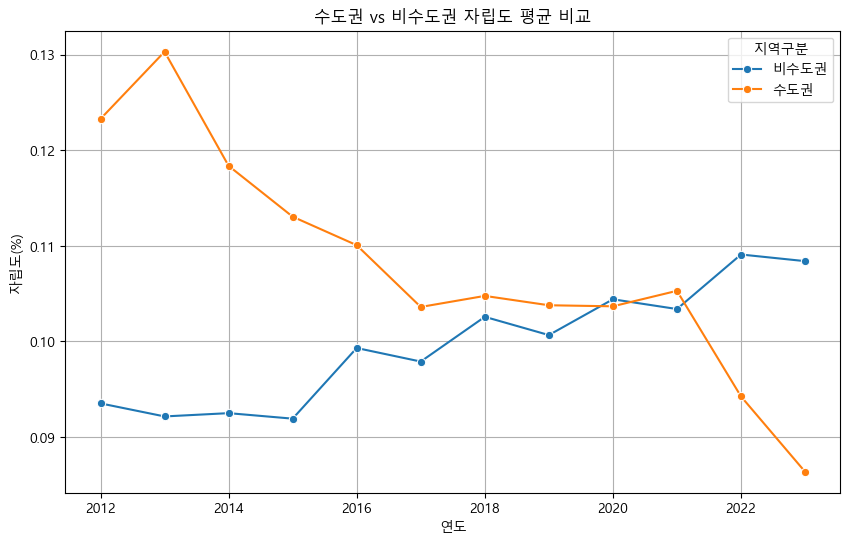

In [21]:
# 수도권 목록
capital_area = ['서울', '경기', '인천']

# 구분 열 추가
merged_df2['지역구분'] = merged_df2['시도명'].apply(lambda x: '수도권' if x in capital_area else '비수도권')

# 연도별 자립도 평균 비교
avg_by_area = merged_df2.groupby(['연도', '지역구분'])['자립도(%)'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_by_area, x='연도', y='자립도(%)', hue='지역구분', marker='o')
plt.title("수도권 vs 비수도권 자립도 평균 비교")
plt.grid(True)
plt.show()


C:\Users\gus10\AppData\Local\Temp\ipykernel_37944\1974195724.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=growth_df, x='자립도증감률(%)', y='시도명', palette='RdYlGn')


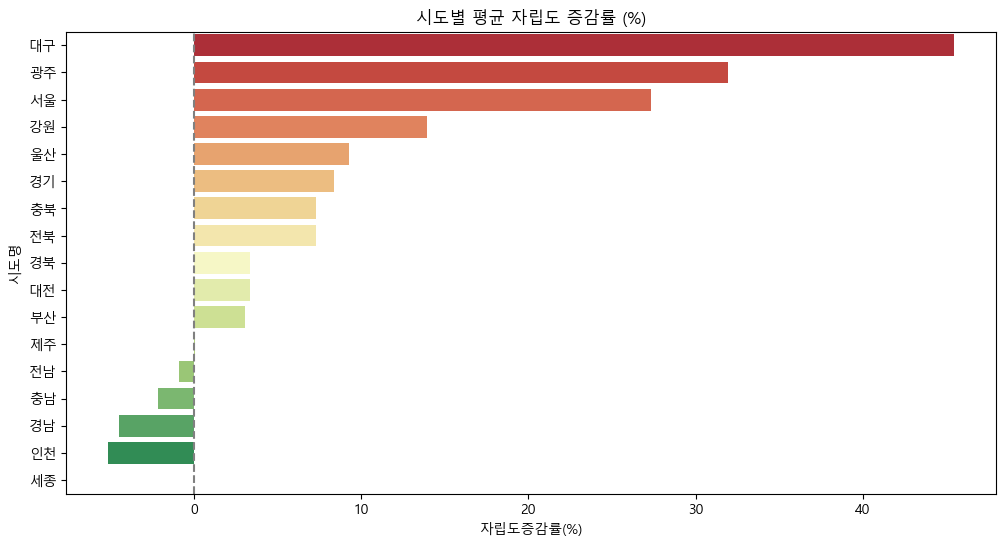

In [22]:
# 연도별 자립도 증감률 계산
merged_df2.sort_values(by=['시도명', '연도'], inplace=True)
merged_df2['자립도증감률(%)'] = merged_df2.groupby('시도명')['자립도(%)'].pct_change() * 100

# 증감률 평균 계산
growth_df = merged_df2.groupby('시도명')['자립도증감률(%)'].mean().reset_index()
growth_df.sort_values(by='자립도증감률(%)', ascending=False, inplace=True)

# 바플롯 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=growth_df, x='자립도증감률(%)', y='시도명', palette='RdYlGn')
plt.title("시도별 평균 자립도 증감률 (%)")
plt.axvline(0, color='gray', linestyle='--')
plt.show()


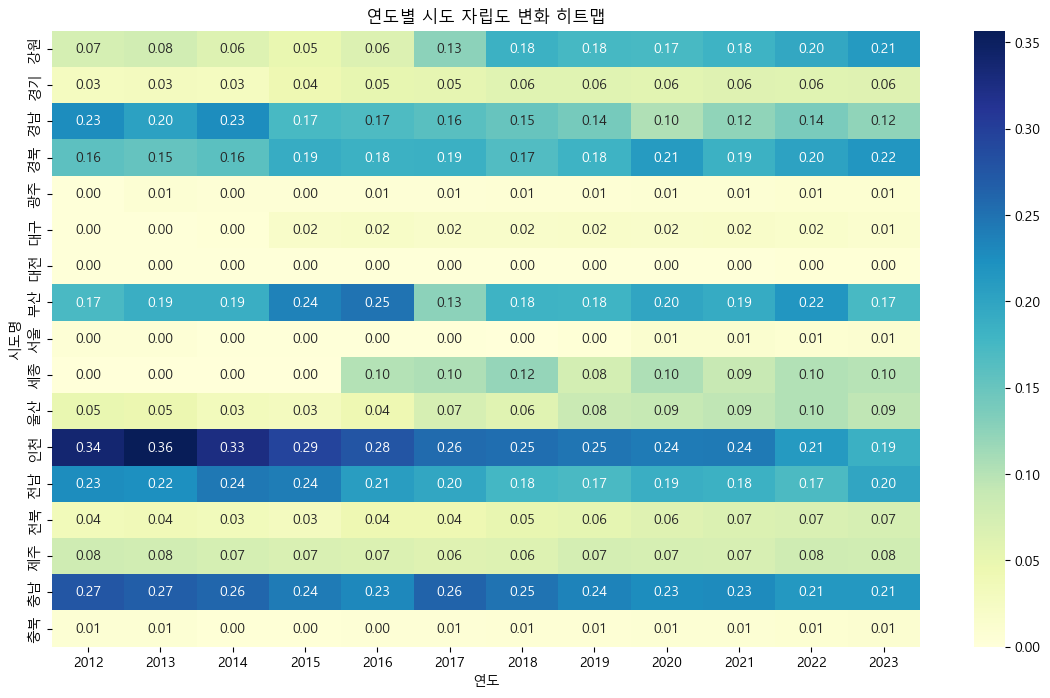

In [23]:
pivot_df = merged_df2.pivot_table(index='시도명', columns='연도', values='자립도(%)')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("연도별 시도 자립도 변화 히트맵")
plt.show()


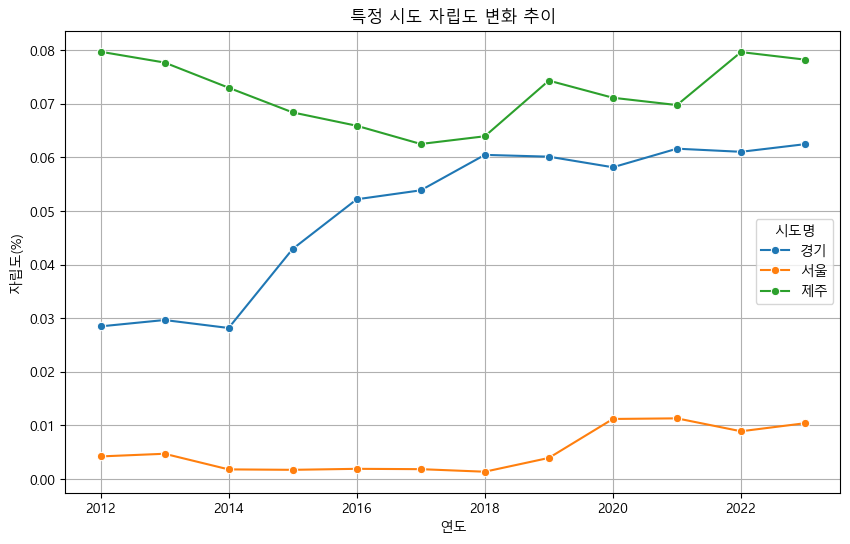

In [24]:
target_areas = ['서울', '경기', '제주']
target_df = merged_df2[merged_df2['시도명'].isin(target_areas)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=target_df, x='연도', y='자립도(%)', hue='시도명', marker='o')
plt.title("특정 시도 자립도 변화 추이")
plt.grid(True)
plt.show()
